# Quick Start - From Python
Here we present a broad overview of using the PyBigDFT library to drive BigDFT calculations using Python. If you have installed from source, you should make sure you have setup the proper environment variables using the following command:

```
source install/bin/bigdftvars.sh
```

## System Manipulation
Here we define a system which is compsed of two fragments: H2 and Helium.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
from BigDFT.Atoms import Atom
from BigDFT.Visualization import InlineVisualizer

In [3]:
# Create Three Atoms
at1 = Atom({"r": [0, 0, 0], "sym": "H", "units": "bohr"})
at2 = Atom({"r": [0, 0, 1.4], "sym": "H", "units": "bohr"})
at3 = Atom({"r": [10, 0, 0], "sym": "He", "units": "bohr"})

# Construct a System from Two Fragments (H2, He)
sys = System()
sys["H2:1"] = Fragment([at1, at2])
sys["He:2"] = Fragment([at3])

# Iterate Over The System
for fragid, frag in sys.items():
    for at in frag:
        print(fragid, at.sym, at.get_position())

H2:1 H [0.0, 0.0, 0.0]
H2:1 H [0.0, 0.0, 1.4]
He:2 He [10.0, 0.0, 0.0]


In [4]:
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Calculation
Calculate the created system using a grid spacing of $0.4$ and the PBE functional. A logfile is generated from which we can access the computed properties. This logfile has built in properties and can be accessed like a dictionary.

In [5]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_hgrid(0.4)
inp.set_xc("PBE")
inp["perf"] = {"calculate_forces": False,
               "multipole_preserving": True}

In [6]:
from BigDFT.Calculators import SystemCalculator
calc = SystemCalculator(skip=True, verbose=False)

In [7]:
log = calc.run(sys=sys, input=inp, name="quick", run_dir="scratch")

In [8]:
print(log.energy)
print(log.log["Memory Consumption Report"]
             ["Memory occupation"])

-4.053822554529116
{'Peak Value (MB)': 230.69, 'for the array': 'f_i', 'in the routine': 'vxcpostprocessing', 'Memory Peak of process': '371.112 MB'}


## Periodic Systems (optional)
The code can treat also extended systems.
We setup a BCC unit cell of iron and perform the calculation using a 2x2x2 k-point grid with a Monkhorst-Pack grid.

In [9]:
from BigDFT.UnitCells import UnitCell

In [10]:
pat = Atom({"Fe": [0, 0, 0], "units": "angstroem"})
psys = System({"CEL:0": Fragment([pat])})
psys.cell = UnitCell([2.867, 2.867, 2.867], units="angstroem")

In [11]:
psys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
inp = Inputfile()
inp.set_hgrid(0.3)
inp.set_xc("LDA")
inp.set_kpt_mesh(method='mpgrid',ngkpt=[2, 2, 2])

In [13]:
log = calc.run(sys=psys, input=inp, name="psys", run_dir="scratch")

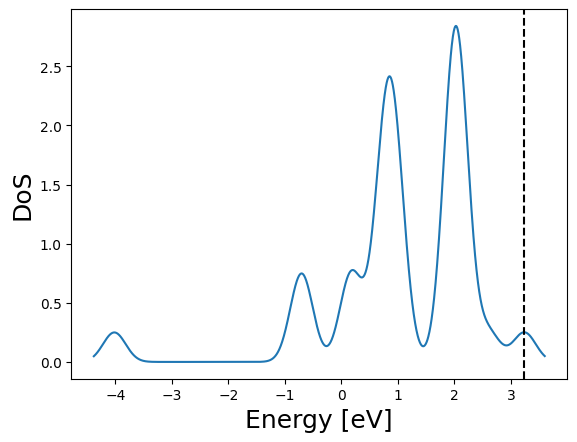

In [14]:
_ = log.get_dos().plot()

## File I/O
Read and write a PDB file.

In [15]:
sys.to_file('scratch/temp.pdb')

In [16]:
from BigDFT.IO import read_pdb

In [17]:
with open("scratch/temp.pdb", "r") as ifile:
    sys = read_pdb(ifile)